In [1]:
from mne_bids import BIDSPath
from os.path import join
import numpy as np
import pandas as pd
import h5py
import re

In [2]:
fname = 'ecg20230819-151345.h5' # this is just me pressing random buttons
fpath = join('logs', fname)
f = h5py.File(fpath, 'r')

In [3]:
t_ecg = [sample[0] for sample in f['ecg_raw']]
x = np.stack([sample[1] for sample in f['ecg_raw']])
ecg = x[:, 0]
ecg = pd.DataFrame({'time': t_ecg, 'ecg': ecg})

t_stim = [sample[0] for sample in f['stim_size']]
sync_stim = [sample[1] for sample in f['stim_size']]
async_stim = [sample[2] for sample in f['stim_size']]
stims = pd.DataFrame({
    'time': t_stim, 
    'syncronous': sync_stim, 
    'asyncronous': async_stim
})

physio = pd.merge(ecg, stims, on = 'time')
physio.head()

,time,ecg,syncronous,asyncronous
0,1.071375e+07,0.837361,0.005976,0.005976
1,1.071375e+07,0.322055,0.009845,0.009845
2,1.071375e+07,-0.126459,0.015809,0.015809
3,1.071375e+07,-0.342333,0.024743,0.024743
4,1.071375e+07,-0.342870,0.037749,0.037749


In [4]:
t_event = [sample[0] for sample in f['experiment_events']]
events = [sample[1] for sample in f['experiment_events']]
_stringify = lambda s: re.findall("'(\w+)'", str(s))[0] # rms weird encoding
stringify = lambda s: s if isinstance(s, str) else _stringify(s)
events = [stringify(ev) for ev in events]
sync_color = stringify(f['experiment_events'][0][-1])
async_color = 'blue' if sync_color == 'red' else 'red'
events = pd.DataFrame({'onset': t_event, 'key': events})
events['dominant_color'] = events.key.replace({
    'left': 'red', 'right': 'blue', 
    'start': pd.NA, 'end': pd.NA
})
events['dominant'] = events.dominant_color.replace({
    sync_color: 'syncronous', 
    async_color: 'asyncronous'
})
durations = events.onset.diff()
durations.iloc[[1, -1]] = np.nan
durations = durations.append(pd.Series([np.nan]))
durations = durations.reset_index(drop = True)
events.insert(1, 'duration', durations)
event_types = events.key.replace({'left': 'keypress', 'right': 'keypress'})
events.insert(0, 'trial', event_types)
events.key = events.key.replace({'start': pd.NA, 'end': pd.NA})

In [5]:
# make timestamps relative to start of rivalry stimuli
start_t = events[events.trial == 'start'].onset[0]
events.onset -= start_t
physio.time -= start_t
# and get rid of surplus ECG data 
physio = physio[physio.time >= -1.]
print('Physio starts at %.02f seconds.'%physio.time.min())
events.head() # should be in format of a BIDS event file

Physio starts at -1.00 seconds.


,trial,onset,duration,key,dominant_color,dominant
0,start,0.000000,NaN,<NA>,<NA>,<NA>
1,keypress,1.130731,NaN,left,red,asyncronous
2,keypress,1.347095,0.216365,right,blue,syncronous
3,keypress,1.670523,0.323428,left,red,asyncronous
4,keypress,1.889564,0.219040,right,blue,syncronous


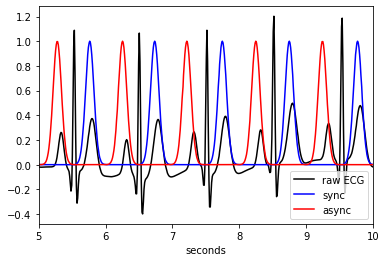

In [6]:
from matplotlib import pyplot as plt
plt.plot(physio.time, physio.ecg, color = 'black', label = 'raw ECG')
plt.plot(physio.time, physio['syncronous'], color = sync_color, label = 'sync')
plt.plot(physio.time, physio['asyncronous'], color = async_color, label = 'async')
plt.xlim(5, 10)
plt.xlabel('seconds')
plt.legend()
plt.show()

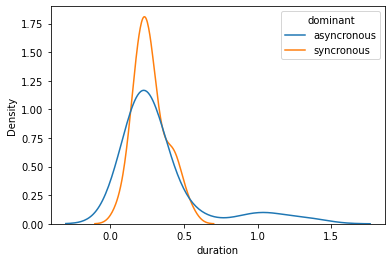

In [7]:
import seaborn as sns
sns.kdeplot(data = events, x = 'duration', hue = 'dominant')
plt.show()

In [8]:
from scipy.stats import mannwhitneyu
sync_durations = events.duration[events.dominant == 'syncronous']
async_durations = events.duration[events.dominant == 'asyncronous']
mannwhitneyu(sync_durations, async_durations, nan_policy = 'omit')

MannwhitneyuResult(statistic=730.0, pvalue=0.7705691404891177)